# Supervised Algorithms For The Detection Of COVID-19 From Chest CT Scan Images

### Import necessary libraries

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import VotingClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from imutils import paths
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import mahotas
from IPython.display import Image
from time import time
%matplotlib inline
print('Libraries successfully imported')

Libraries successfully imported


### Extract the Raw Pixel Intensities

In [2]:
def image_to_feature_vector(image):
	return cv2.resize(image, (60, 60)).flatten()

### Extract a 3D color histogram from the HSV colorspace to characterize the color distribution of the pixels in the images

In [3]:
def extract_color_histogram(image, bins=(8, 8, 8)):
#Extract using the supplied number of `bins` per channel,\
#then perform "in place" normalization in OpenCV, and return the flattened histogram as the feature vector
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
		[0, 256, 0, 256, 0, 256])
	cv2.normalize(hist, hist)
	return hist.flatten()

### Extract the Haralick Texture features using Mahotas, and return the feature vector

In [4]:
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the Haralick Texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

### Extract the Threshold Adjacency Statistics features using Mahotas, and return the feature vector

In [5]:
def fd_tas(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the Threshold Adjacency Statistics feature vector
    value = mahotas.features.tas(gray) 
    return value

### Specify the directory for the CT scan images, and initialize the matrices

In [6]:
# grab the list of images that we'll be describing
print("[INFO] Loading images...")
imagePaths = list(paths.list_images("Images-processed/"))
rawImages = []
histogram = []
hara = []
tas = []
labels = []
features = []

[INFO] Loading images...


### Benchmark function

In [7]:
results = []
def benchmark(clf, name):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
    
    print("classification report:")
    print(classification_report(y_test, pred))

    print("confusion matrix:")
    print(confusion_matrix(y_test, pred))

    print()
    clf_descr = name
    return clf_descr, score, train_time, test_time

### Loop over the input images:
#### 1) load the image and extract the class label (assuming that our path is in the format: /path/to/dataset/{class}.{image_num}.jpg
#### 2) extract the Raw Pixel Intensity, the Color Histogram, the Haralick Texture, and Threshold Adjacency Statistics features
#### 3) update the matricies respectively

In [8]:
start_time = time()
for (i, imagePath) in enumerate(imagePaths):

	image = cv2.imread(imagePath)
	label = imagePath.split(os.path.sep)[-1].split(".")[0]

	pixels = image_to_feature_vector(image)
	haralick = fd_haralick(image)
	tass = fd_tas(image)
	hist = extract_color_histogram(image)
    

	rawImages.append(pixels)
	histogram.append(hist)
	tas.append(tass)
	hara.append(haralick)
	labels.append(label)
    
	if i > 0 and i % 100 == 0:    # show an update every 100 images
		print("[INFO] Processed {}/{}".format(i, len(imagePaths)))
print("[INFO] Processed {}/{}".format(i+1, len(imagePaths)))
print("--- %s seconds ---" % (time() - start_time))


[INFO] Processed 100/2481
[INFO] Processed 200/2481
[INFO] Processed 300/2481
[INFO] Processed 400/2481
[INFO] Processed 500/2481
[INFO] Processed 600/2481
[INFO] Processed 700/2481
[INFO] Processed 800/2481
[INFO] Processed 900/2481
[INFO] Processed 1000/2481
[INFO] Processed 1100/2481
[INFO] Processed 1200/2481
[INFO] Processed 1300/2481
[INFO] Processed 1400/2481
[INFO] Processed 1500/2481
[INFO] Processed 1600/2481
[INFO] Processed 1700/2481
[INFO] Processed 1800/2481
[INFO] Processed 1900/2481
[INFO] Processed 2000/2481
[INFO] Processed 2100/2481
[INFO] Processed 2200/2481
[INFO] Processed 2300/2481
[INFO] Processed 2400/2481
[INFO] Processed 2481/2481
--- 454.0340578556061 seconds ---


### Show some information on the memory consumed each matrix

In [9]:
rawImages = np.array(rawImages)
histogram = np.array(histogram)
labels = np.array(labels)
hara = np.array(hara)
tas = np.array(tas)
features = np.concatenate((hara, tas), axis=1)
features = np.concatenate((features, histogram), axis=1)

print("[INFO] pixels matrix: {} {:.2f}MB".format(
	rawImages.shape, rawImages.nbytes / (1024 * 1000.0)))
print("[INFO] histogram matrix: {} {:.2f}MB".format(
	histogram.shape, histogram.nbytes / (1024 * 1000.0)))
print("[INFO] haralick matrix: {} {:.2f}MB".format(
    hara.shape, hara.nbytes / (1024 * 1000.0)))
print("[INFO] TAS matrix: {} {:.2f}MB".format(
    tas.shape, tas.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {} {:.2f}MB".format(
    features.shape, features.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: (2481, 10800) 26.17MB
[INFO] histogram matrix: (2481, 512) 4.96MB
[INFO] haralick matrix: (2481, 13) 0.25MB
[INFO] TAS matrix: (2481, 54) 1.05MB
[INFO] features matrix: (2481, 579) 11.22MB


### Split partition the data into training and testing splits, using 80% of the data for training and 20% for testing, with a random state of 10

In [10]:
(trainRI, testRI, trainRL, testRL) = train_test_split(rawImages, labels, test_size=0.20, random_state=10)
(trainHara, testHara, trainHaraL, testHaraL) = train_test_split(hara, labels, test_size=0.20, random_state=10)
(trainTas, testTas, trainTasL, testTasL) = train_test_split(tas, labels, test_size=0.20, random_state=10)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(histogram, labels, test_size=0.20, random_state=10)

(trainF, testF, trainFL, testFL) = train_test_split(features, labels, test_size=0.20, random_state=10)

In [11]:
y_train_b = trainFL.tolist()
y_test_b = testFL.tolist()

/home/amr/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Training Data')

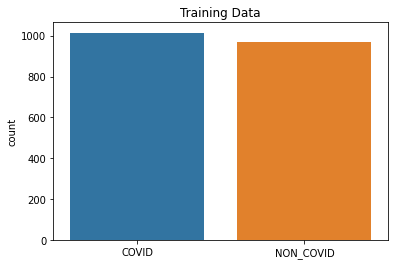

In [12]:
import seaborn as sns
sns.countplot(y_train_b, order = ['COVID', 'NON_COVID'])
plt.title('Training Data')

/home/amr/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Testing Data')

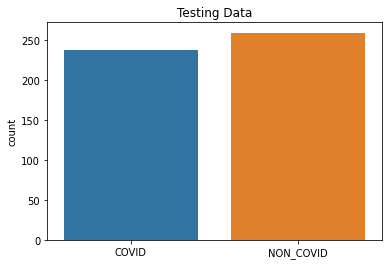

In [13]:
sns.countplot(y_test_b, order = ['COVID', 'NON_COVID'])
plt.title('Testing Data')

## A. Training the algorithms using the Raw Pixel Intensities

### Show a sample of CT Scan Images

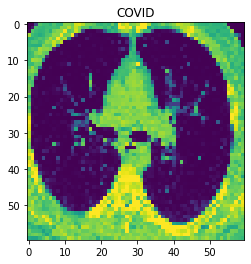

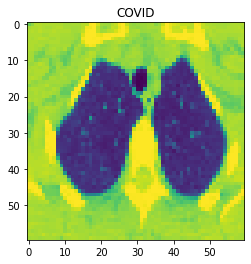

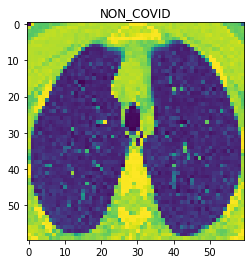

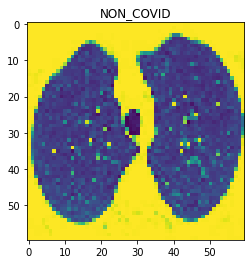

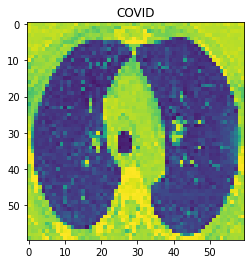

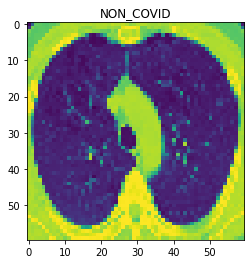

In [14]:
imagePaths = list(paths.list_images("Images-processed/"))
for (i, imagePath) in enumerate(imagePaths):
    if i>= 6: break
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (60, 60))
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    plt.imshow(img)
    plt.title(label)
    plt.show()

### Specify the inputs

In [15]:
X = rawImages
y = labels
X_train = trainRI
X_test = testRI
y_train = trainRL
y_test = testRL

### Perform standardization by centering and scaling the training set and the test set

In [16]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Train and evaluate a k-NN classifer on the raw pixel intensities

In [17]:
print("[INFO] evaluating k-NN on raw pixel accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
results.append(benchmark(knn, 'k-NN on Raw Pixels'))

[INFO] evaluating k-NN on raw pixel accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 1.753s
test time:  25.170s
accuracy:   0.944
classification report:
              precision    recall  f1-score   support

       COVID       0.94      0.95      0.94       238
   NON_COVID       0.95      0.94      0.95       259

    accuracy                           0.94       497
   macro avg       0.94      0.94      0.94       497
weighted avg       0.94      0.94      0.94       497

confusion matrix:
[[225  13]
 [ 15 244]]



### Train and evaluate a Linear SVM classifer on the raw pixel intensities

In [18]:
print("[INFO] evaluating Linear SVM on raw pixel accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on Raw Pixels'))

[INFO] evaluating Linear SVM on raw pixel accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 32.045s
test time:  7.145s
accuracy:   0.769
dimensionality: 10800
density: 1.000000
classification report:
              precision    recall  f1-score   support

       COVID       0.77      0.74      0.75       238
   NON_COVID       0.77      0.80      0.78       259

    accuracy                           0.77       497
   macro avg       0.77      0.77      0.77       497
weighted avg       0.77      0.77      0.77       497

confusion matrix:
[[175  63]
 [ 52 207]]



### Train and evaluate an SVM classifer using the RBF kernel on the raw pixel intensities

#### 1) using C parameter = 10

In [19]:
print("[INFO] evaluating RBF SVM raw pixel accuracy with C=10...")
rbf_svc = svm.SVC(kernel='rbf', C = 10, gamma = 'scale')
results.append(benchmark(rbf_svc, 'RBF SVM with C=10 on Raw Pixels'))

[INFO] evaluating RBF SVM raw pixel accuracy with C=10...
________________________________________________________________________________
Training: 
SVC(C=10)
train time: 55.051s
test time:  10.983s
accuracy:   0.960
classification report:
              precision    recall  f1-score   support

       COVID       0.97      0.95      0.96       238
   NON_COVID       0.95      0.97      0.96       259

    accuracy                           0.96       497
   macro avg       0.96      0.96      0.96       497
weighted avg       0.96      0.96      0.96       497

confusion matrix:
[[226  12]
 [  8 251]]



#### 2) using C parameter = 1

In [20]:
print("[INFO] evaluating RBF SVM on raw pixel accuracy with C=1...")
rbf_svc = svm.SVC(kernel='rbf', C = 1, gamma = 'scale')
results.append(benchmark(rbf_svc, 'RBF SVM with C=1 on Raw Pixels'))

[INFO] evaluating RBF SVM on raw pixel accuracy with C=1...
________________________________________________________________________________
Training: 
SVC(C=1)
train time: 41.982s
test time:  10.695s
accuracy:   0.922
classification report:
              precision    recall  f1-score   support

       COVID       0.93      0.90      0.92       238
   NON_COVID       0.91      0.94      0.93       259

    accuracy                           0.92       497
   macro avg       0.92      0.92      0.92       497
weighted avg       0.92      0.92      0.92       497

confusion matrix:
[[214  24]
 [ 15 244]]



#### 3) using C parameter = 0.1

In [21]:
print("[INFO] evaluating RBF SVM on raw pixel accuracy with C=0.1...")
rbf_svc = svm.SVC(kernel='rbf', C = 0.1, gamma = 'scale')
results.append(benchmark(rbf_svc, 'RBF SVM with C=0.1 on Raw Pixels'))

[INFO] evaluating RBF SVM on raw pixel accuracy with C=0.1...
________________________________________________________________________________
Training: 
SVC(C=0.1)
train time: 52.676s
test time:  13.414s
accuracy:   0.797
classification report:
              precision    recall  f1-score   support

       COVID       0.84      0.71      0.77       238
   NON_COVID       0.77      0.87      0.82       259

    accuracy                           0.80       497
   macro avg       0.80      0.79      0.79       497
weighted avg       0.80      0.80      0.80       497

confusion matrix:
[[170  68]
 [ 33 226]]



### Train and evaluate a Decision Tree Classifier on the raw pixel intensities

In [22]:
print("[INFO] evaluating Decision Tree on raw pixel accuracy...")
dt = DecisionTreeClassifier()
results.append(benchmark(dt, 'Decision Tree on Raw Pixels'))

[INFO] evaluating Decision Tree on raw pixel accuracy...
________________________________________________________________________________
Training: 
DecisionTreeClassifier()
train time: 15.446s
test time:  0.090s
accuracy:   0.734
classification report:
              precision    recall  f1-score   support

       COVID       0.71      0.76      0.73       238
   NON_COVID       0.77      0.71      0.73       259

    accuracy                           0.73       497
   macro avg       0.74      0.74      0.73       497
weighted avg       0.74      0.73      0.73       497

confusion matrix:
[[182  56]
 [ 76 183]]



### Train and evaluate a Voting Classifier with hard voting on the raw pixel intensities

In [23]:
print("[INFO] evaluating Voting Classifier on raw pixel accuracy...")
estimator = []
estimator.append(('1', knn))
estimator.append(('2', svm.SVC(kernel='rbf', C=10, gamma = 'scale')))
estimator.append(('3', dt))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on Raw Pixels'))

[INFO] evaluating Voting Classifier on raw pixel accuracy...
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier(n_neighbors=3)),
                             ('2', SVC(C=10)),
                             ('3', DecisionTreeClassifier())])
train time: 71.970s
test time:  33.950s
accuracy:   0.970
classification report:
              precision    recall  f1-score   support

       COVID       0.97      0.96      0.97       238
   NON_COVID       0.97      0.98      0.97       259

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497

confusion matrix:
[[229   9]
 [  6 253]]



## B. Training the algorithms using the Color Histogram features

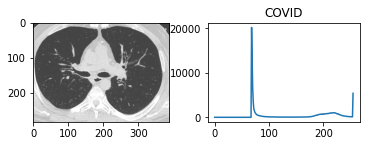

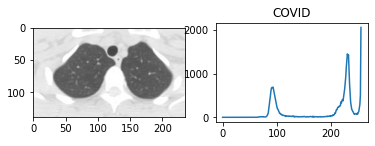

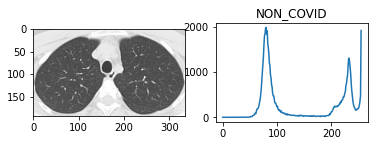

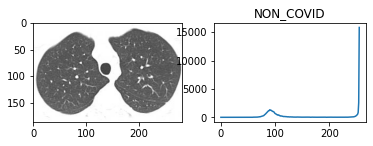

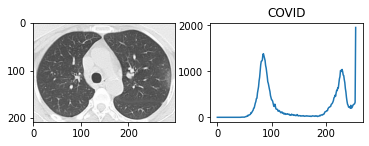

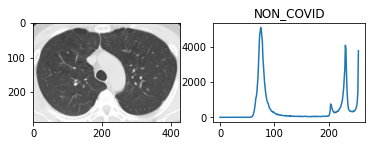

In [24]:
imagePaths = list(paths.list_images("Images-processed/"))
for (i, imagePath) in enumerate(imagePaths):
    if i>= 6: break
    img = cv2.imread(imagePath)
    hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
    plt.subplot(221), plt.imshow(img, 'gray')
    plt.subplot(222), plt.plot(hist_full)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    plt.title(label)
    plt.show()

### Specify the inputs

In [25]:
X = histogram
y = labels
X_train = trainFeat
X_test = testFeat
y_train = trainLabels
y_test = testLabels

### Perform standardization by centering and scaling the training set and the test set

In [26]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

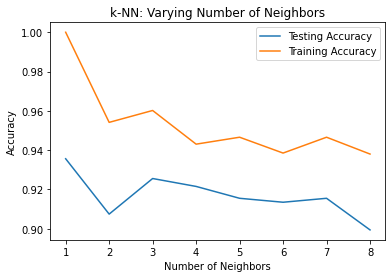

In [27]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the color histogram representations

In [28]:
print("[INFO] evaluating k-NN on color histogram accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
results.append(benchmark(knn, 'k-NN on Color Histograms'))

[INFO] evaluating k-NN on color histogram accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.157s
test time:  0.762s
accuracy:   0.926
classification report:
              precision    recall  f1-score   support

       COVID       0.90      0.95      0.92       238
   NON_COVID       0.95      0.91      0.93       259

    accuracy                           0.93       497
   macro avg       0.93      0.93      0.93       497
weighted avg       0.93      0.93      0.93       497

confusion matrix:
[[225  13]
 [ 24 235]]



### Train and evaluate a Linear SVM classifer on the color histogram representations

In [29]:
print("[INFO] evaluating Linear SVM color histogram accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on Color Histograms'))

[INFO] evaluating Linear SVM color histogram accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 1.375s
test time:  0.242s
accuracy:   0.867
dimensionality: 512
density: 0.041016
classification report:
              precision    recall  f1-score   support

       COVID       0.92      0.79      0.85       238
   NON_COVID       0.83      0.93      0.88       259

    accuracy                           0.87       497
   macro avg       0.87      0.86      0.87       497
weighted avg       0.87      0.87      0.87       497

confusion matrix:
[[189  49]
 [ 17 242]]



### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the color histogram representations and print the classification report for the model

In [30]:
steps = [('SVM', svm.SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.1, 1, 10, 100],
              'SVM__gamma':[0.1, 1, 10, 100]}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 1}


In [31]:
print("[INFO] evaluating RBF SVM on color histogram with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C = 10, gamma = 1)
results.append(benchmark(rbf_svc, 'RBF SVM on Color Histograms'))

[INFO] evaluating RBF SVM on color histogram with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=10, gamma=1)
train time: 1.087s
test time:  0.207s
accuracy:   0.940
classification report:
              precision    recall  f1-score   support

       COVID       0.94      0.94      0.94       238
   NON_COVID       0.94      0.94      0.94       259

    accuracy                           0.94       497
   macro avg       0.94      0.94      0.94       497
weighted avg       0.94      0.94      0.94       497

confusion matrix:
[[223  15]
 [ 15 244]]



### Plot the Percision-Recall Curve

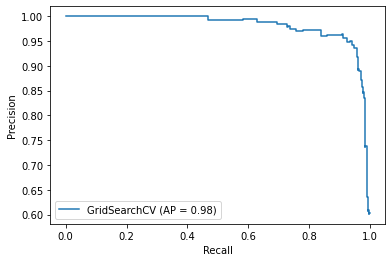

In [32]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
disp = plot_precision_recall_curve(cv, X_test, y_test)

### Train and evaluate a Decision Tree Classifier

In [33]:
print("[INFO] evaluating Decision Tree on color histogram accuracy...")
dt = DecisionTreeClassifier()
results.append(benchmark(dt, 'Decision Tree on Color Histograms'))

[INFO] evaluating Decision Tree on color histogram accuracy...
________________________________________________________________________________
Training: 
DecisionTreeClassifier()
train time: 0.021s
test time:  0.001s
accuracy:   0.926
classification report:
              precision    recall  f1-score   support

       COVID       0.92      0.92      0.92       238
   NON_COVID       0.93      0.93      0.93       259

    accuracy                           0.93       497
   macro avg       0.93      0.93      0.93       497
weighted avg       0.93      0.93      0.93       497

confusion matrix:
[[220  18]
 [ 19 240]]



### Train and evaluate a Voting Classifier with hard voting on the Color Histogram features

In [34]:
print("[INFO] evaluating Voting Classifier on color histogram accuracy...")
estimator = []
estimator.append(('1', knn))
estimator.append(('2', svm.SVC(kernel='rbf', C=10, gamma = 1)))
estimator.append(('3', dt))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on Color Histograms'))

[INFO] evaluating Voting Classifier on color histogram accuracy...
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier(n_neighbors=3)),
                             ('2', SVC(C=10, gamma=1)),
                             ('3', DecisionTreeClassifier())])
train time: 1.149s
test time:  0.990s
accuracy:   0.940
classification report:
              precision    recall  f1-score   support

       COVID       0.93      0.94      0.94       238
   NON_COVID       0.95      0.94      0.94       259

    accuracy                           0.94       497
   macro avg       0.94      0.94      0.94       497
weighted avg       0.94      0.94      0.94       497

confusion matrix:
[[224  14]
 [ 16 243]]



## C. Training the algorithms using the Haralick Texture features

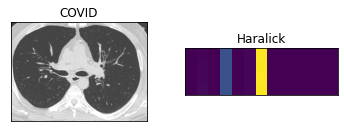

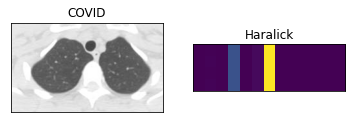

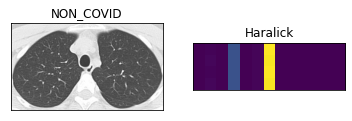

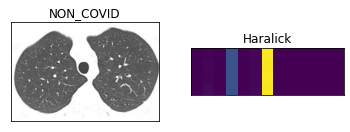

In [35]:
imagePaths = list(paths.list_images("Images-processed/"))
for (i, imagePath) in enumerate(imagePaths):
    if i>= 4: break
    img = cv2.imread(imagePath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray)
    plt.subplot(2,2,1),plt.imshow(img, cmap = 'gray')
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    plt.title(label), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,2),plt.imshow(haralick)
    plt.title('Haralick'), plt.xticks([]), plt.yticks([])
    plt.show()

### Specify the inputs

In [36]:
X = hara
y = labels
X_train = trainHara
X_test = testHara
y_train = trainHaraL
y_test = testHaraL

### Perform standardization by centering and scaling the training set and the test set

In [37]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

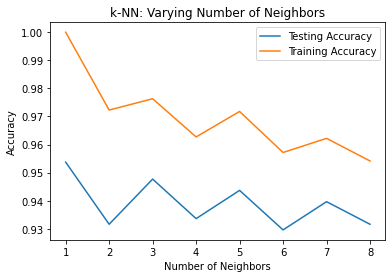

In [38]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Haralick Texture features

In [39]:
print("[INFO] evaluating k-NN on Haralick Texture accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
results.append(benchmark(knn, 'k-NN on Haralick Texture'))

[INFO] evaluating k-NN on Haralick Texture accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.004s
test time:  0.034s
accuracy:   0.948
classification report:
              precision    recall  f1-score   support

       COVID       0.93      0.96      0.95       238
   NON_COVID       0.96      0.94      0.95       259

    accuracy                           0.95       497
   macro avg       0.95      0.95      0.95       497
weighted avg       0.95      0.95      0.95       497

confusion matrix:
[[228  10]
 [ 16 243]]



### Train and evaluate a Linear SVM classifer on the Haralick Texture features

In [40]:
print("[INFO] evaluating Linear SVM on Haralick Texture accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on Haralick Texture'))

[INFO] evaluating Linear SVM on Haralick Texture accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 0.087s
test time:  0.005s
accuracy:   0.883
dimensionality: 13
density: 1.000000
classification report:
              precision    recall  f1-score   support

       COVID       0.90      0.85      0.87       238
   NON_COVID       0.87      0.92      0.89       259

    accuracy                           0.88       497
   macro avg       0.88      0.88      0.88       497
weighted avg       0.88      0.88      0.88       497

confusion matrix:
[[202  36]
 [ 22 237]]



### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the Haralick Texture features and print the classification report for the model

In [41]:
steps = [('SVM', svm.SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.1, 1, 10, 100],
              'SVM__gamma':[0.1, 1, 10, 100]}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'SVM__C': 100, 'SVM__gamma': 1}


In [42]:
print("[INFO] evaluating RBF SVM on Haralick Texture with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C = 100, gamma = 1)
results.append(benchmark(rbf_svc, 'RBF SVM on Raw Pixels'))

[INFO] evaluating RBF SVM on Haralick Texture with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=100, gamma=1)
train time: 0.166s
test time:  0.015s
accuracy:   0.962
classification report:
              precision    recall  f1-score   support

       COVID       0.95      0.97      0.96       238
   NON_COVID       0.97      0.96      0.96       259

    accuracy                           0.96       497
   macro avg       0.96      0.96      0.96       497
weighted avg       0.96      0.96      0.96       497

confusion matrix:
[[230   8]
 [ 11 248]]



### Train and evaluate a Decision Tree Classifier on the Haralick Texture representations

In [43]:
print("[INFO] evaluating Decision Tree on Haralick Texture accuracy...")
#Train Decision Tree Classifer using default parameters
dt = DecisionTreeClassifier()
results.append(benchmark(dt, 'Decision Tree on Haralick Texture'))

[INFO] evaluating Decision Tree on Haralick Texture accuracy...
________________________________________________________________________________
Training: 
DecisionTreeClassifier()
train time: 0.043s
test time:  0.001s
accuracy:   0.885
classification report:
              precision    recall  f1-score   support

       COVID       0.86      0.90      0.88       238
   NON_COVID       0.91      0.87      0.89       259

    accuracy                           0.89       497
   macro avg       0.89      0.89      0.89       497
weighted avg       0.89      0.89      0.89       497

confusion matrix:
[[215  23]
 [ 34 225]]



### Train and evaluate a Voting Classifier with hard voting on the Haralick Texture representations

In [44]:
print("[INFO] evaluating Voting Classifier on Haralick Texture...")
start_time = time()
estimator = []
estimator.append(('1', knn))
estimator.append(('2', svm.SVC(kernel='rbf', C=100, gamma = 1)))
estimator.append(('3', dt))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on Haralick Texture'))

[INFO] evaluating Voting Classifier on Haralick Texture...
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier(n_neighbors=3)),
                             ('2', SVC(C=100, gamma=1)),
                             ('3', DecisionTreeClassifier())])
train time: 0.219s
test time:  0.055s
accuracy:   0.956
classification report:
              precision    recall  f1-score   support

       COVID       0.95      0.96      0.95       238
   NON_COVID       0.96      0.95      0.96       259

    accuracy                           0.96       497
   macro avg       0.96      0.96      0.96       497
weighted avg       0.96      0.96      0.96       497

confusion matrix:
[[229   9]
 [ 13 246]]



## D. Training the algorithms using Threshold Adjacency Statistics

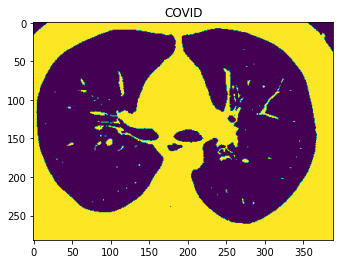

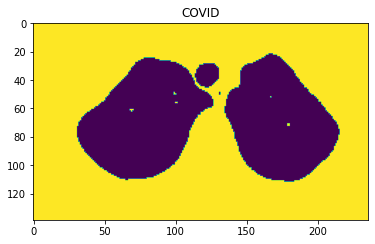

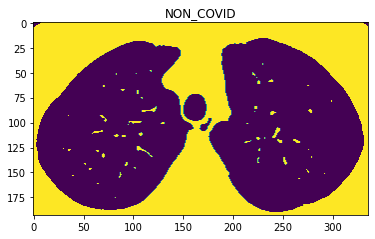

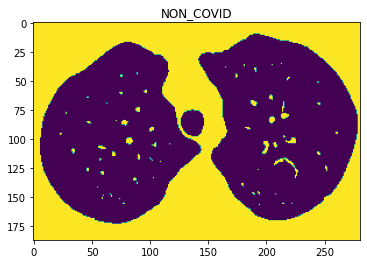

In [45]:
from pylab import imshow, gray, show
from os import path
imagePaths = list(paths.list_images("Images-processed/"))
for (i, imagePath) in enumerate(imagePaths):
    if i>= 4: break
    img = cv2.imread(imagePath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.uint8)
    T_rc = mahotas.rc(gray)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    plt.title(label)
    imshow(gray > T_rc)
    show()

### Specify the inputs

In [46]:
X = tas
y = labels
X_train = trainTas
X_test = testTas
y_train = trainTasL
y_test = testTasL

### Perform standardization by centering and scaling the training set and the test set

In [47]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

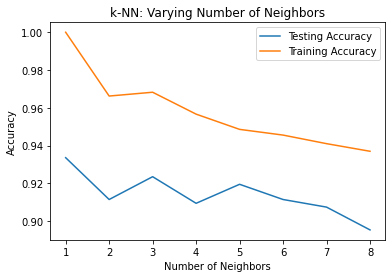

In [48]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Threshold Adjacency Statistics (TAS)

In [49]:
start_time = time()
print("[INFO] evaluating k-NN on TAS accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
results.append(benchmark(knn, 'k-NN on TAS'))

[INFO] evaluating k-NN on TAS accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.013s
test time:  0.091s
accuracy:   0.924
classification report:
              precision    recall  f1-score   support

       COVID       0.93      0.91      0.92       238
   NON_COVID       0.92      0.94      0.93       259

    accuracy                           0.92       497
   macro avg       0.92      0.92      0.92       497
weighted avg       0.92      0.92      0.92       497

confusion matrix:
[[216  22]
 [ 16 243]]



### Train and evaluate a Linear SVM classifer on the TAS representations

In [50]:
print("[INFO] evaluating Linear SVM on TAS accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on TAS'))

[INFO] evaluating Linear SVM on TAS accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 0.219s
test time:  0.018s
accuracy:   0.877
dimensionality: 54
density: 1.000000
classification report:
              precision    recall  f1-score   support

       COVID       0.87      0.87      0.87       238
   NON_COVID       0.88      0.88      0.88       259

    accuracy                           0.88       497
   macro avg       0.88      0.88      0.88       497
weighted avg       0.88      0.88      0.88       497

confusion matrix:
[[207  31]
 [ 30 229]]



### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the TAS representations and print the classification report for the model

In [51]:
steps = [('SVM', svm.SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.1, 1, 10, 100],
              'SVM__gamma':[0.1, 1, 10, 100]}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 0.1}


In [52]:
print("[INFO] evaluating RBF SVM on TAS with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C = 10, gamma = 0.1)
results.append(benchmark(rbf_svc, 'RBF SVM on TAS'))

[INFO] evaluating RBF SVM on TAS with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=10, gamma=0.1)
train time: 0.184s
test time:  0.026s
accuracy:   0.938
classification report:
              precision    recall  f1-score   support

       COVID       0.93      0.94      0.94       238
   NON_COVID       0.94      0.94      0.94       259

    accuracy                           0.94       497
   macro avg       0.94      0.94      0.94       497
weighted avg       0.94      0.94      0.94       497

confusion matrix:
[[223  15]
 [ 16 243]]



### Train and evaluate a Decision Tree Classifier on the TAS representations

In [53]:
print("[INFO] evaluating Decision Tree on TAS...")
#Train Decision Tree Classifer using default parameters
dt = DecisionTreeClassifier()
results.append(benchmark(dt, 'Decision Tree on TAS'))

[INFO] evaluating Decision Tree on TAS...
________________________________________________________________________________
Training: 
DecisionTreeClassifier()
train time: 0.108s
test time:  0.000s
accuracy:   0.873
classification report:
              precision    recall  f1-score   support

       COVID       0.85      0.89      0.87       238
   NON_COVID       0.90      0.86      0.88       259

    accuracy                           0.87       497
   macro avg       0.87      0.87      0.87       497
weighted avg       0.87      0.87      0.87       497

confusion matrix:
[[212  26]
 [ 37 222]]



### Train and evaluate a Voting Classifier with hard voting on the TAS representations

In [54]:
print("[INFO] evaluating Voting Classifier on TAS...")
start_time = time()
estimator = []
estimator.append(('1', knn))
estimator.append(('2', svm.SVC(kernel='rbf', C=10, gamma=0.1)))
estimator.append(('3', dt))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on TAS'))

[INFO] evaluating Voting Classifier on TAS...
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier(n_neighbors=3)),
                             ('2', SVC(C=10, gamma=0.1)),
                             ('3', DecisionTreeClassifier())])
train time: 0.301s
test time:  0.078s
accuracy:   0.944
classification report:
              precision    recall  f1-score   support

       COVID       0.95      0.93      0.94       238
   NON_COVID       0.94      0.96      0.95       259

    accuracy                           0.94       497
   macro avg       0.94      0.94      0.94       497
weighted avg       0.94      0.94      0.94       497

confusion matrix:
[[221  17]
 [ 11 248]]



## E. Training the algorithms using all the features (Color Histogram, Haralink, & TAS)

### Specify the inputs

In [55]:
X = features
y = labels
X_train = trainF
X_test = testF
y_train = trainFL
y_test = testFL
results_feat = []

### Perform standardization by centering and scaling the training set and the test set

In [56]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

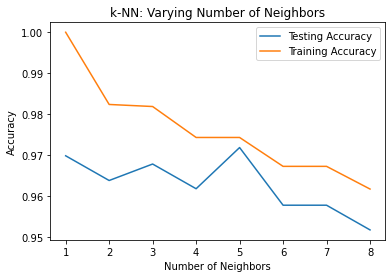

In [57]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Features matrix

In [58]:
print("[INFO] evaluating k-NN on Features accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
results.append(benchmark(knn, 'k-NN on Features'))

[INFO] evaluating k-NN on Features accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.138s
test time:  1.022s
accuracy:   0.968
classification report:
              precision    recall  f1-score   support

       COVID       0.97      0.96      0.97       238
   NON_COVID       0.97      0.97      0.97       259

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497

confusion matrix:
[[229   9]
 [  7 252]]



### Train and evaluate a Linear SVM classifer on the Features matrix

In [59]:
print("[INFO] evaluating Linear SVM on Features accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on Features'))

[INFO] evaluating Linear SVM on Features accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 1.180s
test time:  0.341s
accuracy:   0.946
dimensionality: 579
density: 0.151986
classification report:
              precision    recall  f1-score   support

       COVID       0.94      0.95      0.94       238
   NON_COVID       0.95      0.95      0.95       259

    accuracy                           0.95       497
   macro avg       0.95      0.95      0.95       497
weighted avg       0.95      0.95      0.95       497

confusion matrix:
[[225  13]
 [ 14 245]]



### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the Features matrix and print the classification report for the model

In [60]:
steps = [('SVM', svm.SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.1, 1, 10, 100],
              'SVM__gamma':[0.1, 1, 10, 100]}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 0.1}


In [61]:
print("[INFO] evaluating RBF SVM on Features with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C = 10, gamma = 0.1)
results.append(benchmark(rbf_svc, 'RBF SVM on Features'))

[INFO] evaluating RBF SVM on Features with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=10, gamma=0.1)
train time: 1.317s
test time:  0.297s
accuracy:   0.968
classification report:
              precision    recall  f1-score   support

       COVID       0.97      0.96      0.97       238
   NON_COVID       0.96      0.98      0.97       259

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497

confusion matrix:
[[228  10]
 [  6 253]]



### Train and evaluate a Decision Tree Classifier on the Features matrix

In [62]:
print("[INFO] evaluating Decision Tree on Features...")
dt = DecisionTreeClassifier()
results.append(benchmark(dt, 'Decision Tree on Features'))

[INFO] evaluating Decision Tree on Features...
________________________________________________________________________________
Training: 
DecisionTreeClassifier()
train time: 0.170s
test time:  0.001s
accuracy:   0.905
classification report:
              precision    recall  f1-score   support

       COVID       0.92      0.88      0.90       238
   NON_COVID       0.90      0.93      0.91       259

    accuracy                           0.91       497
   macro avg       0.91      0.90      0.91       497
weighted avg       0.91      0.91      0.91       497

confusion matrix:
[[210  28]
 [ 19 240]]



### Train and evaluate a Voting Classifier with hard voting on the Features matrix

In [63]:
estimator = []
estimator.append(('1', knn))
estimator.append(('2', svm.SVC(kernel='linear')))
estimator.append(('3', svm.SVC(kernel='rbf', C=10, gamma=0.1)))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on Features'))

________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier(n_neighbors=3)),
                             ('2', SVC(kernel='linear')),
                             ('3', SVC(C=10, gamma=0.1))])
train time: 2.383s
test time:  1.413s
accuracy:   0.972
classification report:
              precision    recall  f1-score   support

       COVID       0.97      0.97      0.97       238
   NON_COVID       0.97      0.97      0.97       259

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497

confusion matrix:
[[231   7]
 [  7 252]]



## Benchmark

In [64]:
def scoreof(results):
    indices = np.arange(len(results))
    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results

    x = clf_names
    y = score
    x_pos = [i for i, _ in enumerate(x)]

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x_pos, y, color='b')
    plt.ylabel("Score")
    plt.title("Score")
    plt.xticks(x_pos, x)
    # Turn on the grid
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%f' % float(height),
            ha='center', va='bottom')
    autolabel(rects1)
    plt.show()

In [65]:
def timeof(results, ind):
    indices = np.arange(len(results))
    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results

    training_time = np.array(training_time)
    test_time = np.array(test_time)

    plt.figure(figsize=(15, 15))
    plt.barh(indices + .3, training_time, .3, label="training time", color='c')
    plt.barh(indices + .6, test_time, .3, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')

    for i, c in zip(indices, clf_names):
        plt.text(ind, i, c)

    plt.show()


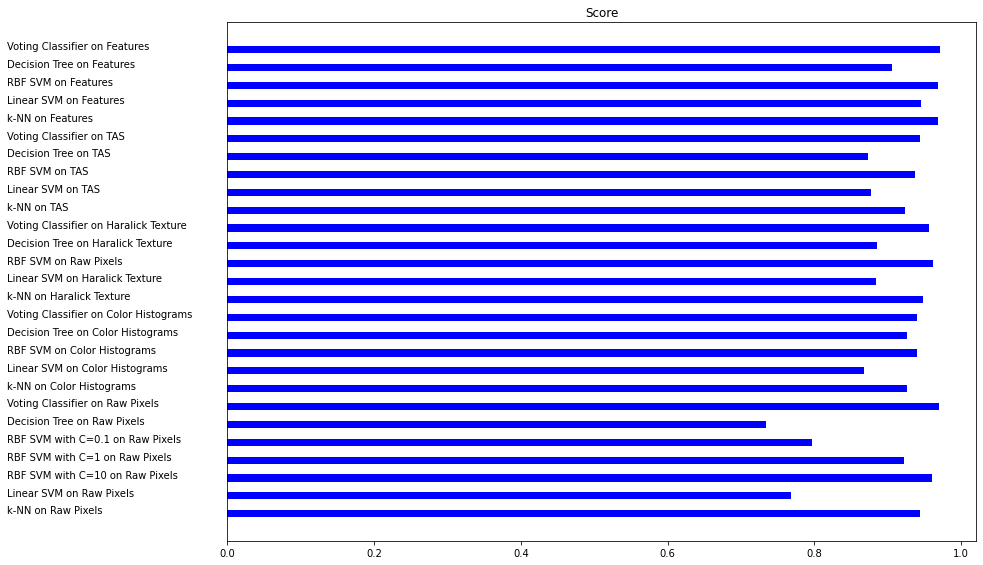

In [79]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results

plt.figure(figsize=(16, 8))
plt.title("Score")
plt.barh(indices, score, .4, label="score", color='blue')
plt.yticks(())
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

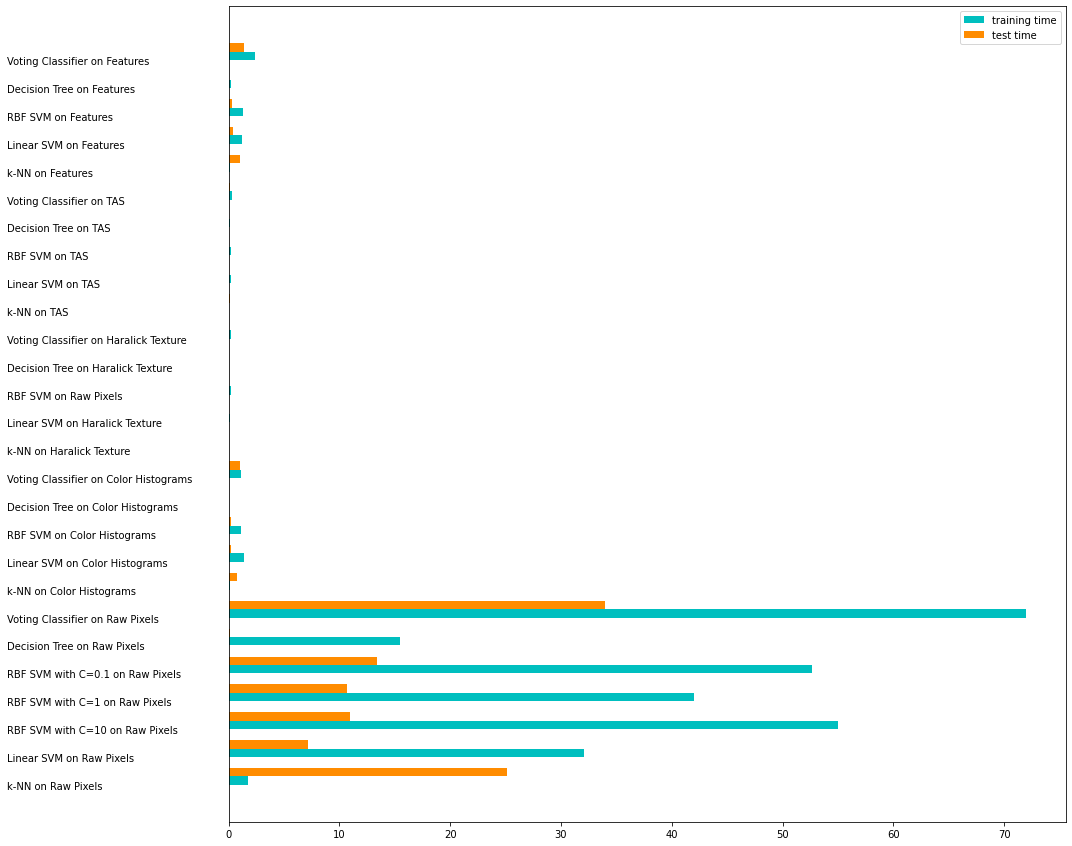

In [78]:
timeof(results, -20)

### Benchmark Features

In [68]:
results_feat = []
for clf, name in (
        (knn, "k-NN"),
        (linear_svc, "Linear SVM"),
        (rbf_svc, "RBF SVM"),
        (dt, "Decision Tree"),
        (vot_hard, "Voting Classifier")):
    print('=' * 80)
    print(name)
    results_feat.append(benchmark(clf, name))


print('=' * 80)
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.

k-NN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.143s
test time:  1.178s
accuracy:   0.968
classification report:
              precision    recall  f1-score   support

       COVID       0.97      0.96      0.97       238
   NON_COVID       0.97      0.97      0.97       259

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497

confusion matrix:
[[229   9]
 [  7 252]]

Linear SVM
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 1.062s
test time:  0.148s
accuracy:   0.946
dimensionality: 579
density: 0.151986
classification report:
              precision    recall  f1-score   support

       COVID       0.94      0.95      0.94       238
   NON_COVID       0.95      0.95      0.95       259

    accuracy  

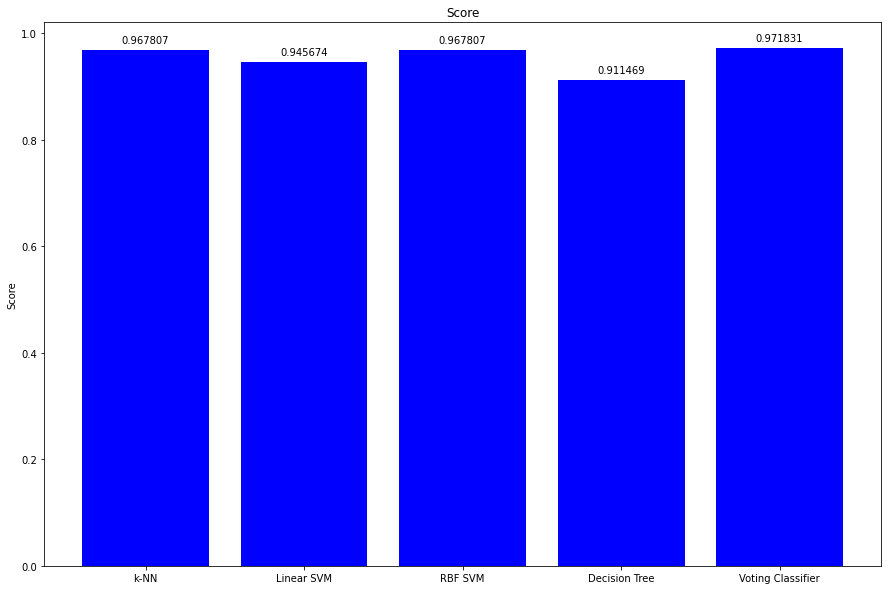

In [69]:
scoreof(results_feat)

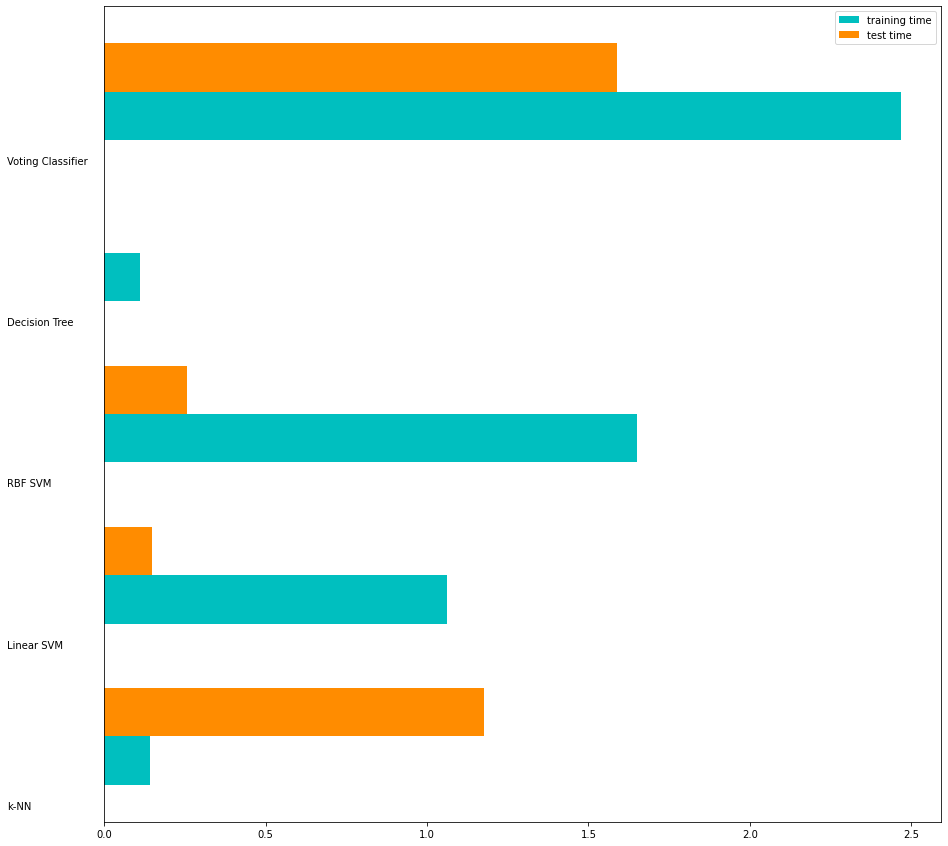

In [70]:
timeof(results_feat, -0.3)

### Mean of 3 runs on Quad-Core Intel® Core™ i5-8250U CPU @ 1.60GHz 6.0 GB memory

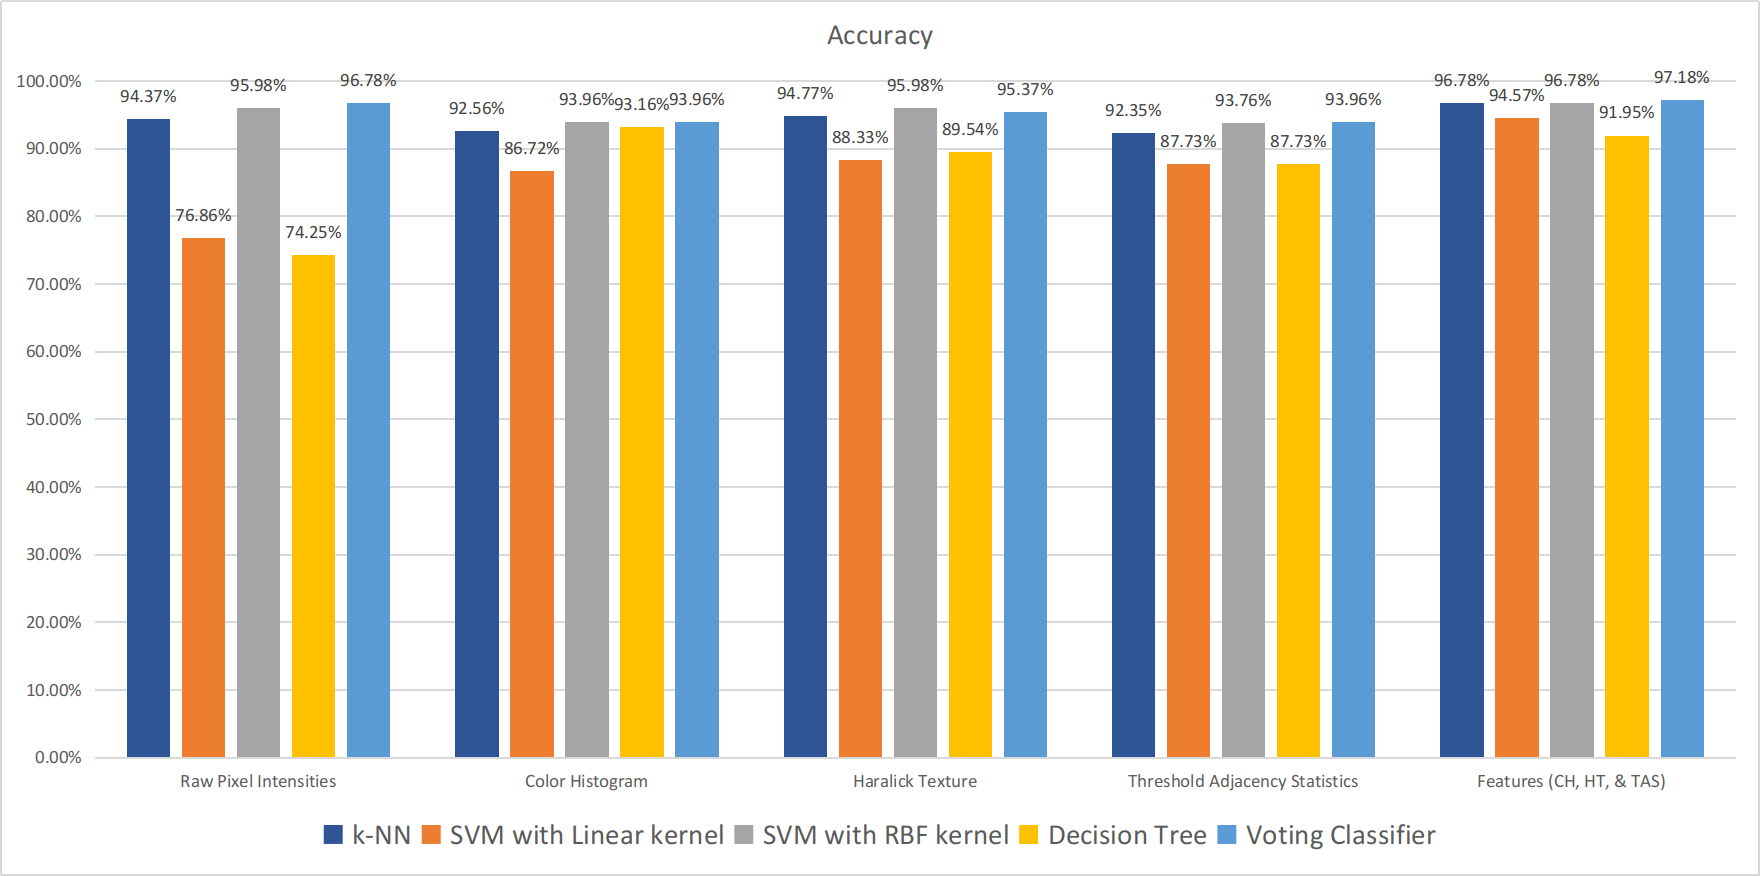

In [71]:
Image("acc.png")

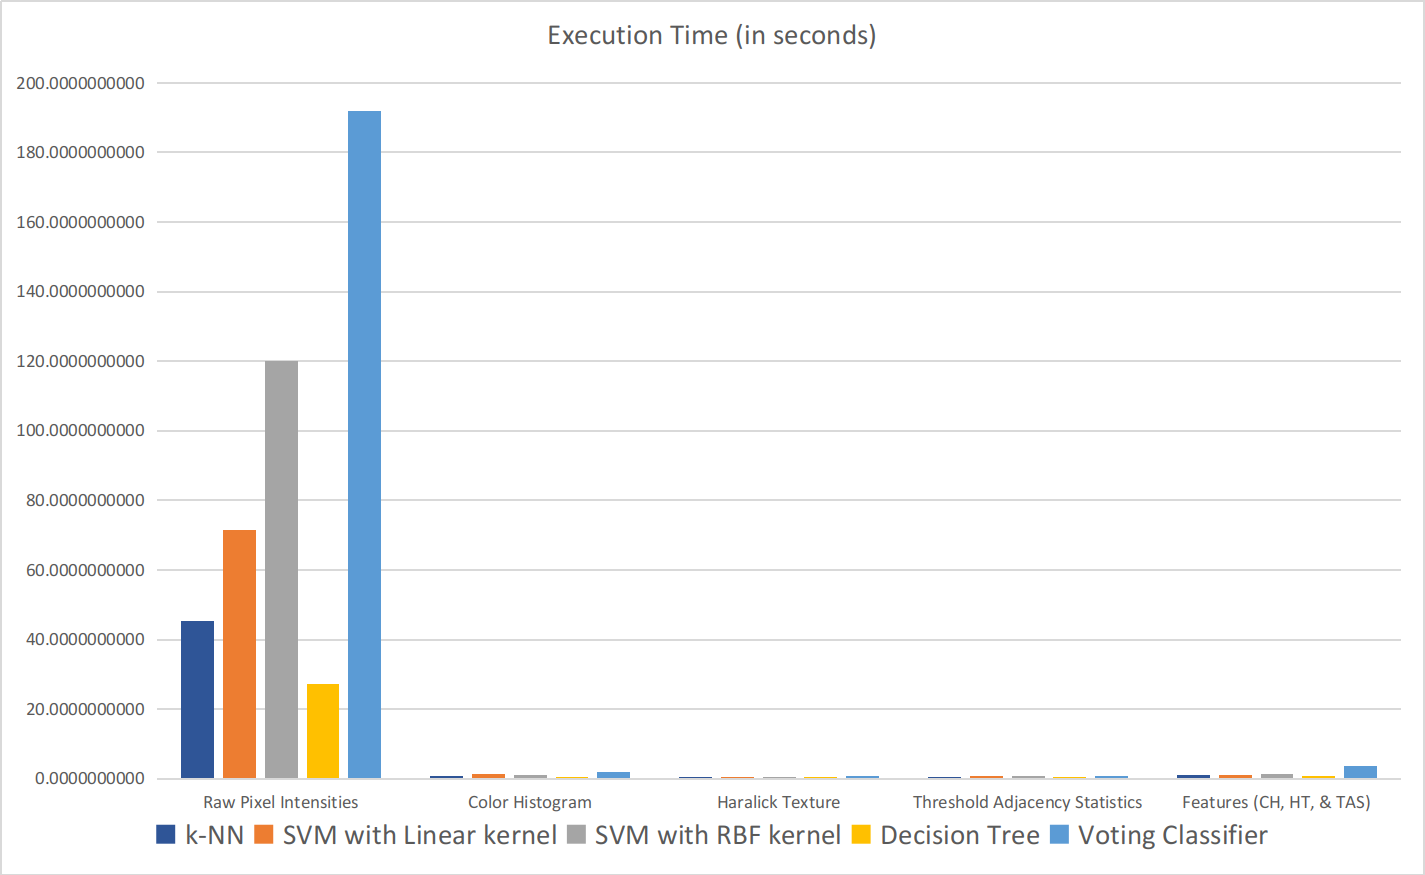

In [72]:
Image("time.png")

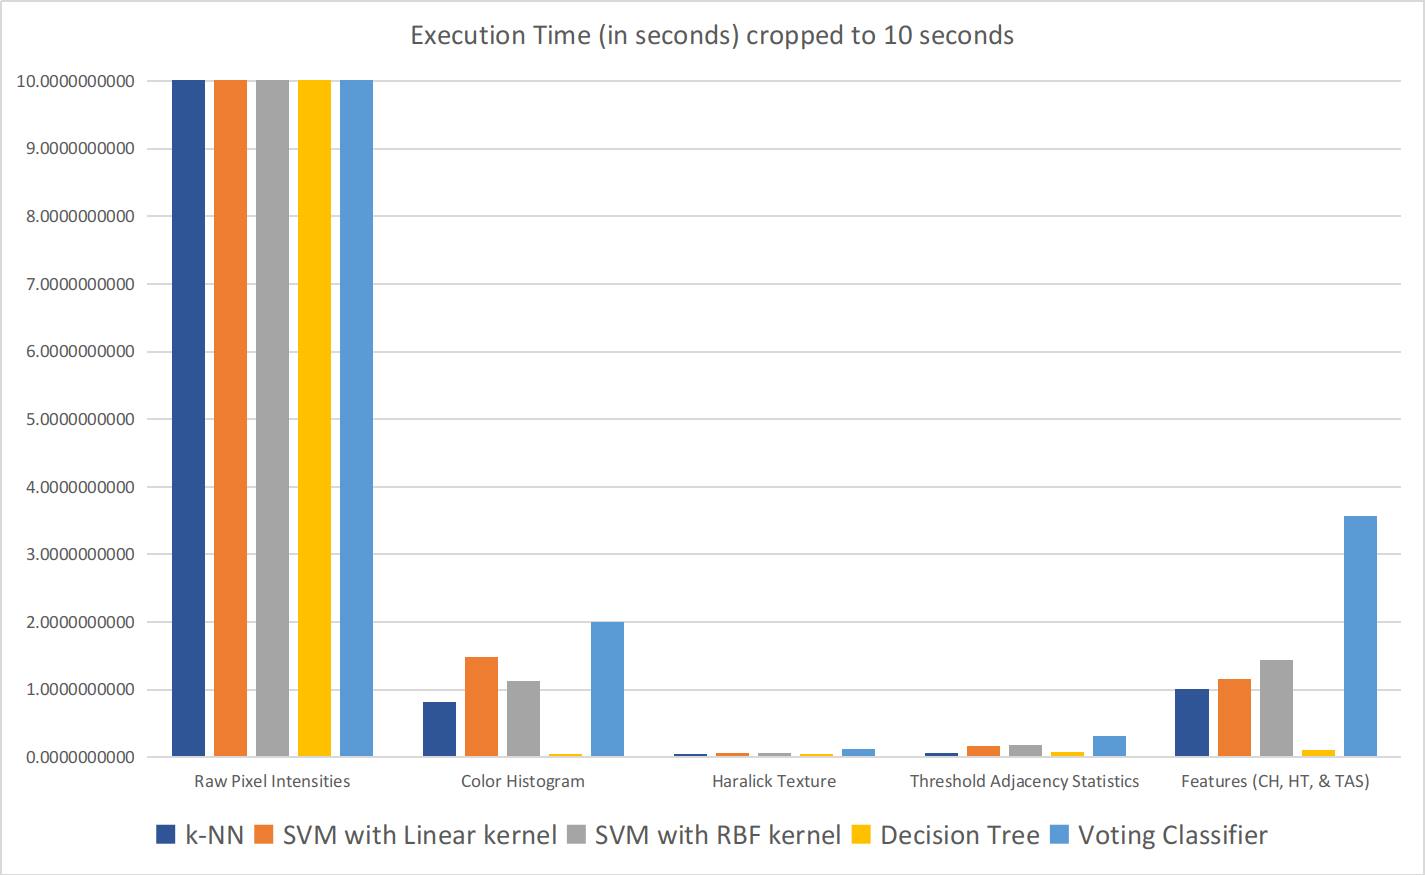

In [73]:
Image("timecrop.png")

## Further method: Neural Networks

### Train and evaluate a Multi-layer Perceptron classifier on the Features matrix

In [74]:
from sklearn.neural_network import MLPClassifier
print("[INFO] evaluating MLPClassifier on Features...")
start_time = time()
mlp = MLPClassifier(hidden_layer_sizes=500)
results_feat.append(benchmark(mlp, 'MLPClassifier'))

[INFO] evaluating MLPClassifier on Features...
________________________________________________________________________________
Training: 
MLPClassifier(hidden_layer_sizes=500)
train time: 58.609s
test time:  0.007s
accuracy:   0.976
classification report:
              precision    recall  f1-score   support

       COVID       0.97      0.97      0.97       238
   NON_COVID       0.98      0.98      0.98       259

    accuracy                           0.98       497
   macro avg       0.98      0.98      0.98       497
weighted avg       0.98      0.98      0.98       497

confusion matrix:
[[232   6]
 [  6 253]]



/home/amr/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [75]:
results_feat

[('k-NN', 0.9678068410462777, 0.1426987648010254, 1.1782410144805908),
 ('Linear SVM', 0.9456740442655935, 1.0621321201324463, 0.14843988418579102),
 ('RBF SVM', 0.9678068410462777, 1.6492679119110107, 0.25823068618774414),
 ('Decision Tree',
  0.9114688128772636,
  0.11203789710998535,
  0.0008800029754638672),
 ('Voting Classifier',
  0.971830985915493,
  2.4688656330108643,
  1.5877325534820557),
 ('MLPClassifier',
  0.9758551307847082,
  58.60931396484375,
  0.007031679153442383)]

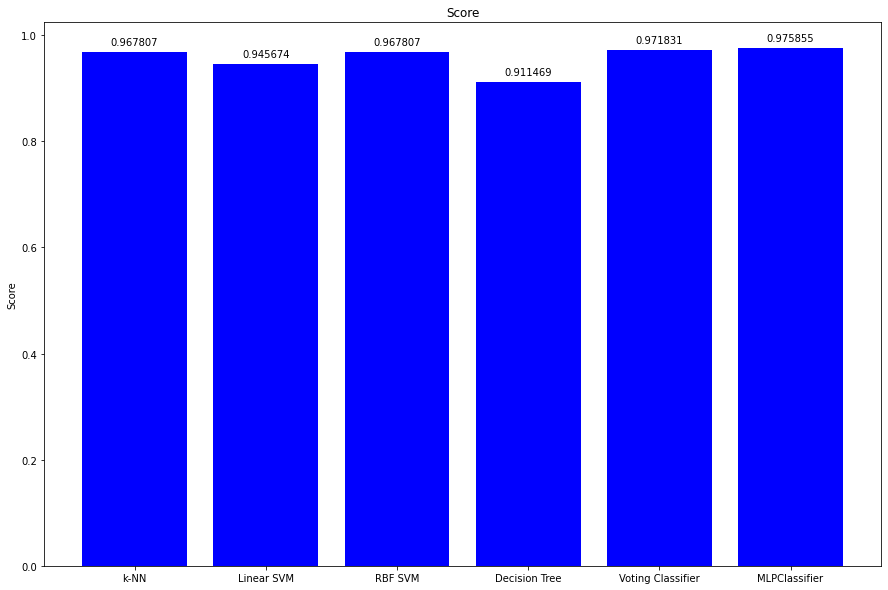

In [76]:
scoreof(results_feat)

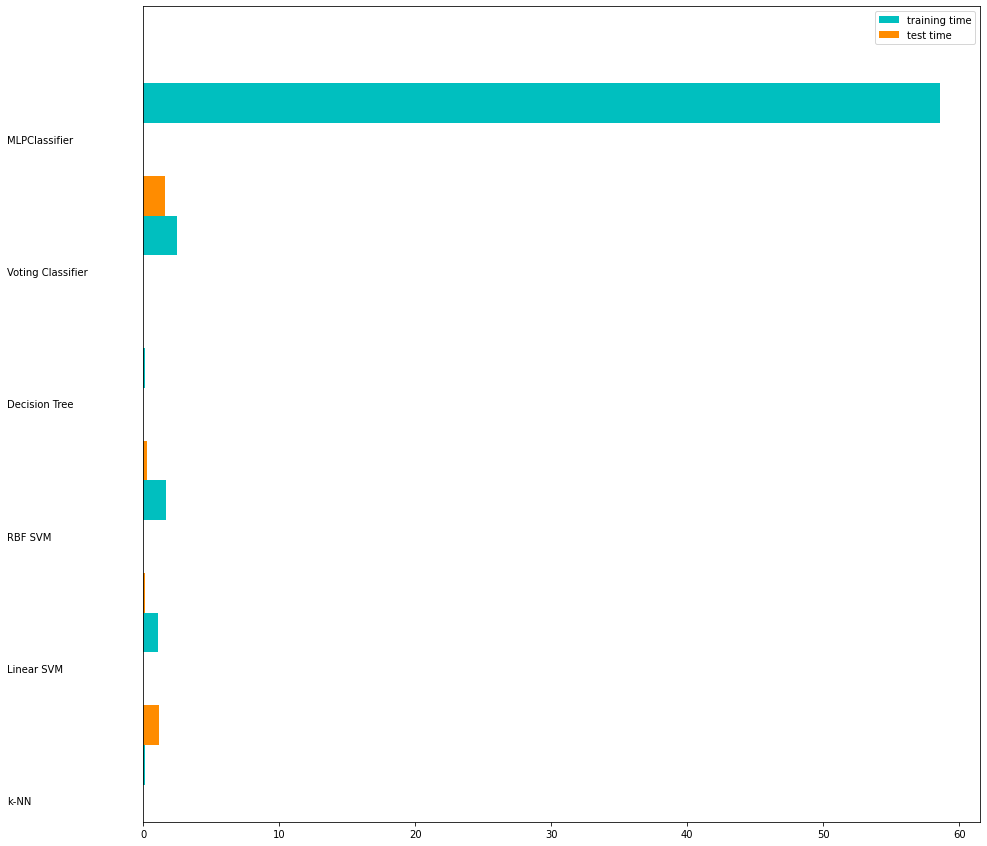

In [83]:
timeof(results_feat, -10)